# Kadai2 MNIST
## Import 

In [1]:
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import random
import numpy as np
import matplotlib.pyplot as plt
import os

## GPU chekcer

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Random seed

In [3]:
# random seedを設定
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

## MNIST

In [4]:
'''Datasetの準備'''
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=False,
                                           transform=transforms.ToTensor(),
                                           download=True)

In [5]:
'''DataLoaderを作成'''
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=100, 
                                          shuffle=True)
print(len(train_loader))
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,  
                                          batch_size=100, 
                                          shuffle=False)
print(len(test_loader))

600
100


## MNIST check

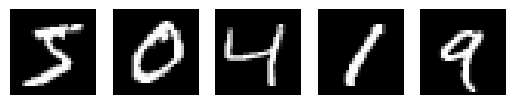

In [6]:
fig, axes = plt.subplots(1, 5)
for i in range(5):
    axes[i].imshow(train_dataset[i][0].view(-1, 28), cmap='gray')
    axes[i].axis("off")

## Hyper Prameter

In [7]:
input = 1
hide1 = 16
hide2 = 32
output = 10
kernel_size = 5
padding = 2

In [8]:
class CNN(nn.Module):
    def __init__(self,input,hide1,hide2,output,kernel_size,padding):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(input, hide1, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(hide1),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(hide1, hide2, kernel_size=5, padding=2),
            nn.BatchNorm2d(hide2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7 * 7 * hide2, output)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(input,hide1,hide2,output,kernel_size,padding).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
def train(train_loader):
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss / len(train_loader)
    return train_loss

In [10]:
def valid(test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = outputs.max(1, keepdim=True)[1]
            labels = labels.view_as(predicted)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc

In [11]:
loss_list = []
val_loss_list = []
val_acc_list = []

In [12]:
for epoch in range(10):
    loss = train(train_loader)
    val_loss, val_acc = valid(test_loader)
    print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss, val_loss, val_acc))
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 0.2097 val_loss: 0.0497 val_acc: 0.9844
epoch 1, loss: 0.0464 val_loss: 0.0417 val_acc: 0.9857
epoch 2, loss: 0.0368 val_loss: 0.0327 val_acc: 0.9896
epoch 3, loss: 0.0276 val_loss: 0.0344 val_acc: 0.9892
epoch 4, loss: 0.0241 val_loss: 0.0280 val_acc: 0.9912
epoch 5, loss: 0.0228 val_loss: 0.0316 val_acc: 0.9892
epoch 6, loss: 0.0201 val_loss: 0.0338 val_acc: 0.9909
epoch 7, loss: 0.0190 val_loss: 0.0367 val_acc: 0.9905
epoch 8, loss: 0.0184 val_loss: 0.0306 val_acc: 0.9914
epoch 9, loss: 0.0142 val_loss: 0.0592 val_acc: 0.9843


In [13]:
np.save('loss_list.npy', np.array(loss_list))
np.save('val_loss_list.npy', np.array(val_loss_list))
np.save('val_acc_list.npy', np.array(val_acc_list))
torch.save(model.state_dict(), 'cnn.pkl')

正解率： 98.42999999999999 %


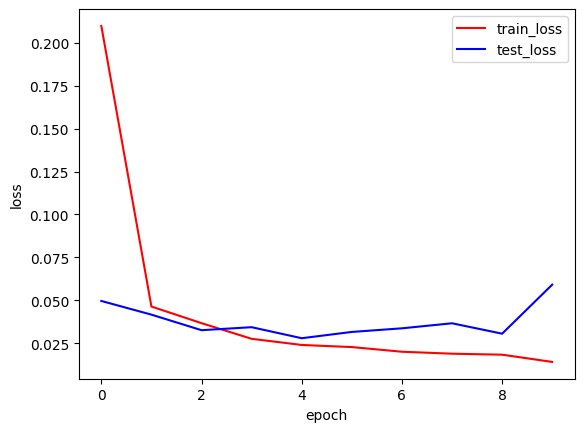

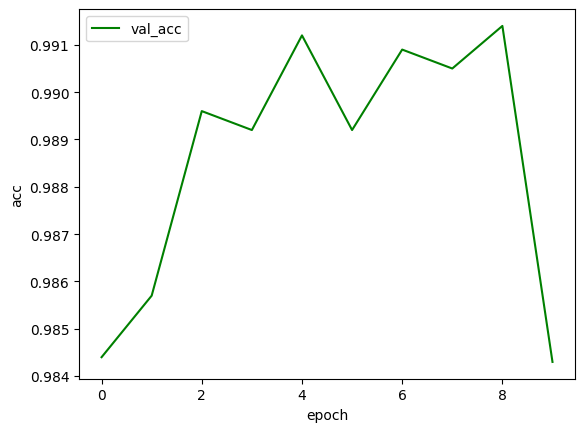

In [14]:
plt.plot(range(10), loss_list, 'r-', label='train_loss')
plt.plot(range(10), val_loss_list, 'b-', label='test_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.figure()
plt.plot(range(10), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
print('正解率：',val_acc_list[-1]*100, '%')